In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from eden.util import configure_logging
import logging
configure_logging(logging.getLogger(),verbosity=2)

In [3]:
'''
getting some data
'''
from eden.converter.graph.gspan import gspan_to_eden
def getgraphs():
    return  gspan_to_eden( 'bursi.pos.gspan' )


We work on this graph


/Users/costa/anaconda/lib/python2.7/site-packages/matplotlib/text.py:52: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if rotation in ('horizontal', None):
/Users/costa/anaconda/lib/python2.7/site-packages/matplotlib/text.py:54: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif rotation == 'vertical':


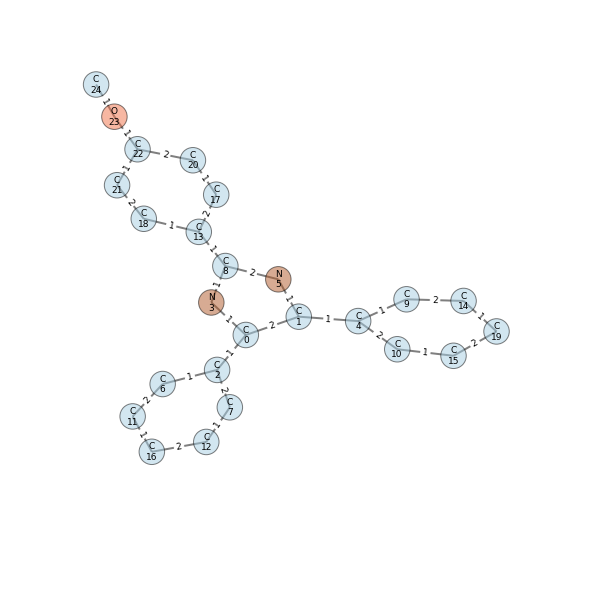

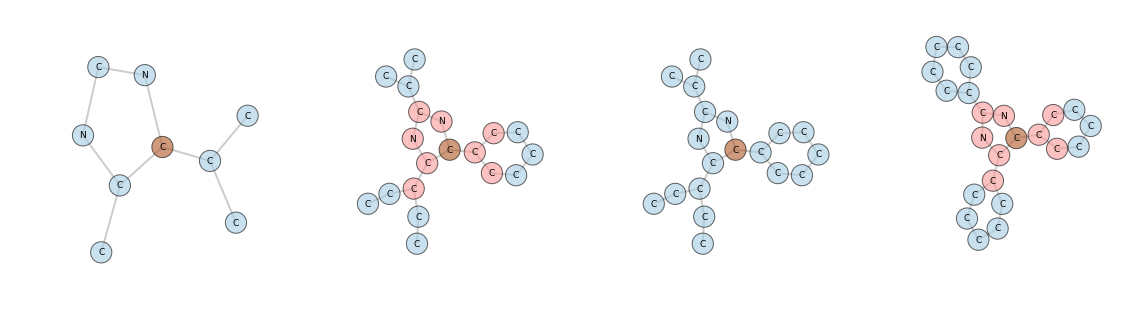

In [4]:
'''
first we test the core/interface extractor, since it is most essential
'''

%matplotlib inline
from eden.converter.graph.gspan import gspan_to_eden
from graphlearn import graphtools as gt
import graphlearn.utils.draw as myutils
import eden.graph as eg
import graphlearn.graphlearn as gl
import numpy as np

from eden.graph import Vectorizer
vectorizer=Vectorizer()

#get a graph
graphs = gspan_to_eden( 'bursi.pos.gspan' )
graph=graphs.next()
from eden.util import display
from eden.modifier.graph.vertex_attributes import colorize  
graphs = colorize([graph],output_attribute = 'color_level', labels = ['C','O','N','P','Cl','Br','S'])    
graph=graphs.next()
print 'We work on this graph'
display.draw_graph(graph, size=10, secondary_vertex_label='ID',
                   colormap='Paired', invert_colormap=False,node_border=0.5, vertex_color='color_level',
                   vertex_alpha=0.5, node_size=650)


def mark_and_draw(cip):
    graph=myutils.cip_to_graph(cip)
    myutils.draw_graph_set_graphlearn(graph, 
                           n_graphs_per_line=7, size=5, 
                           colormap='Paired', invert_colormap=False,node_border=1,
                           vertex_alpha=0.6, edge_alpha=0.2, node_size=450)
    
radius_list=[0,2]
thickness_list=[2,4]
cip=gl.extract_core_and_interface(1,graph,radius_list=radius_list,thickness_list=thickness_list,vectorizer=vectorizer)
mark_and_draw(cip)

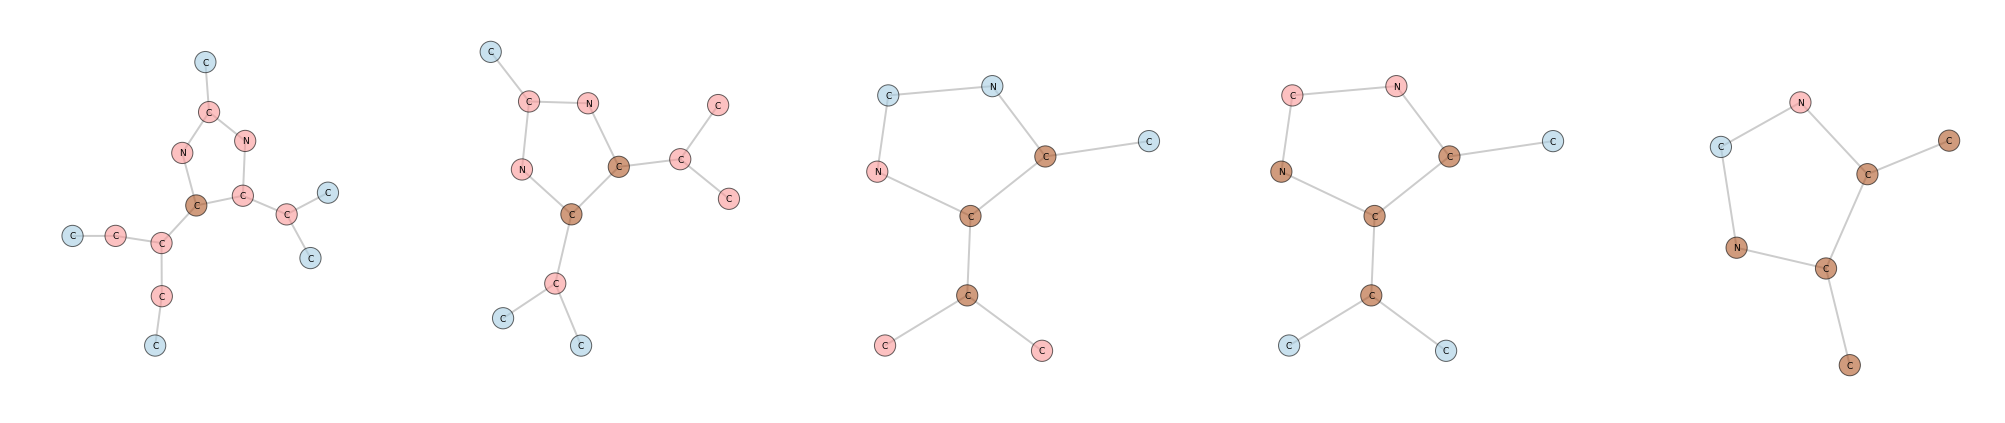

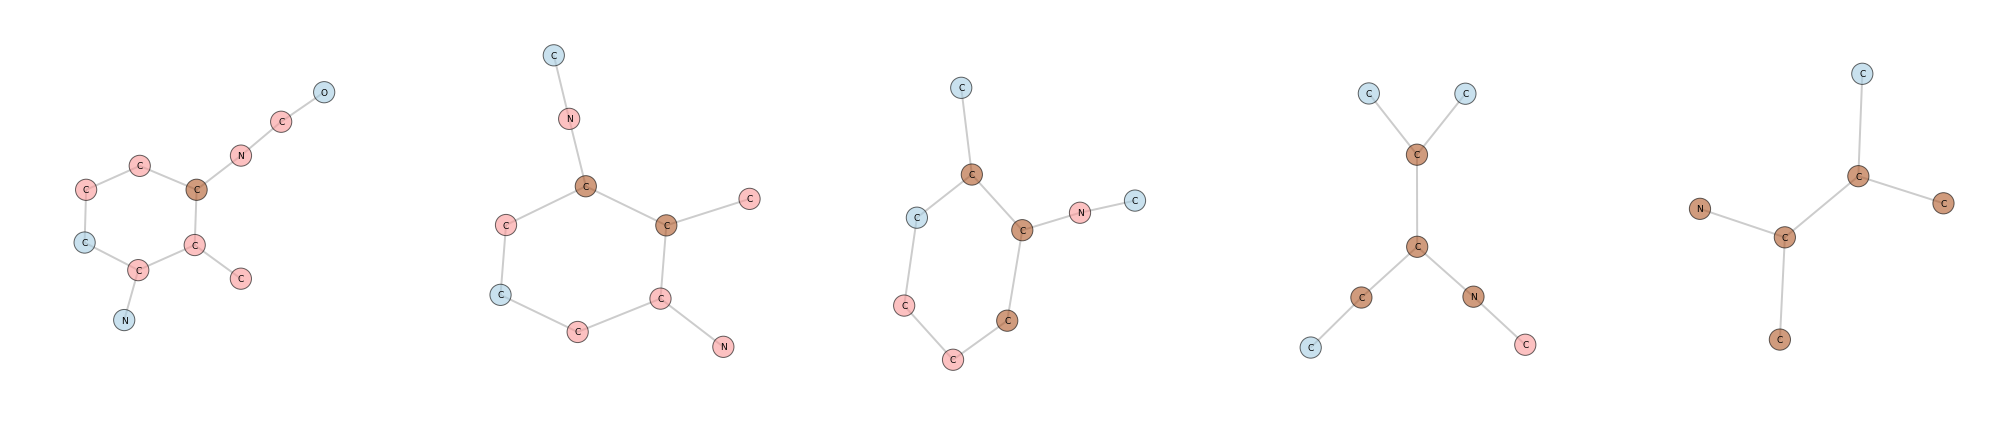

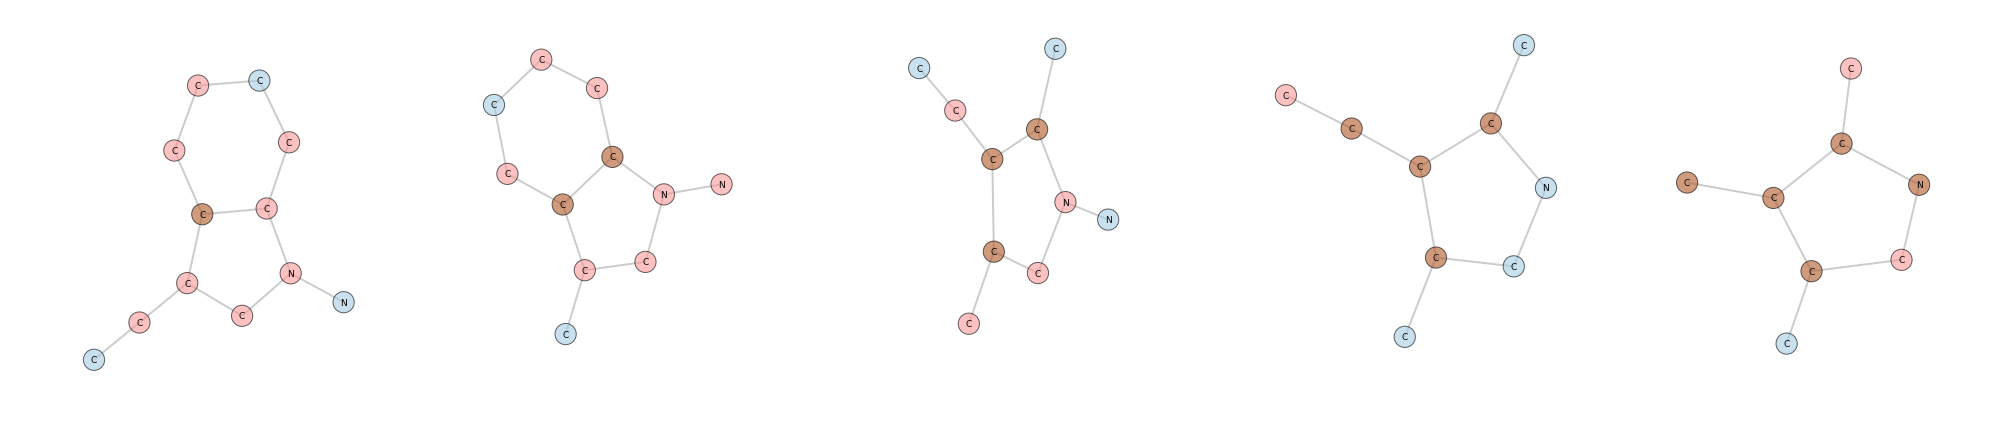

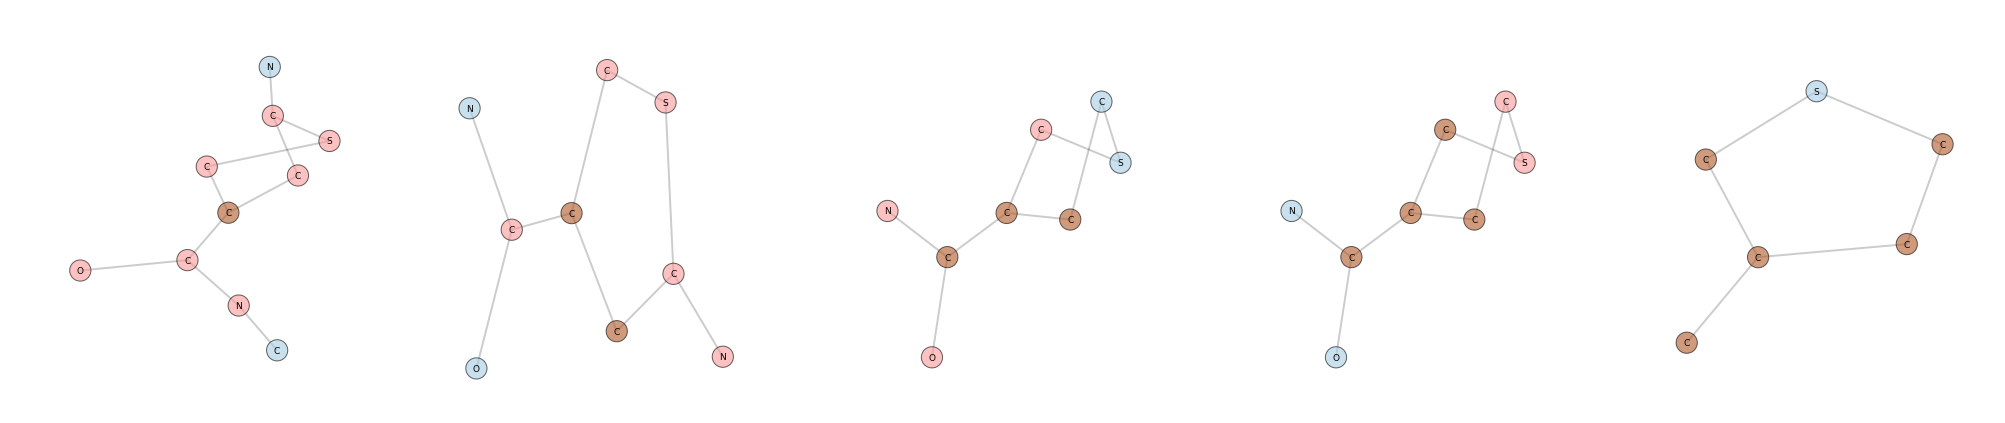

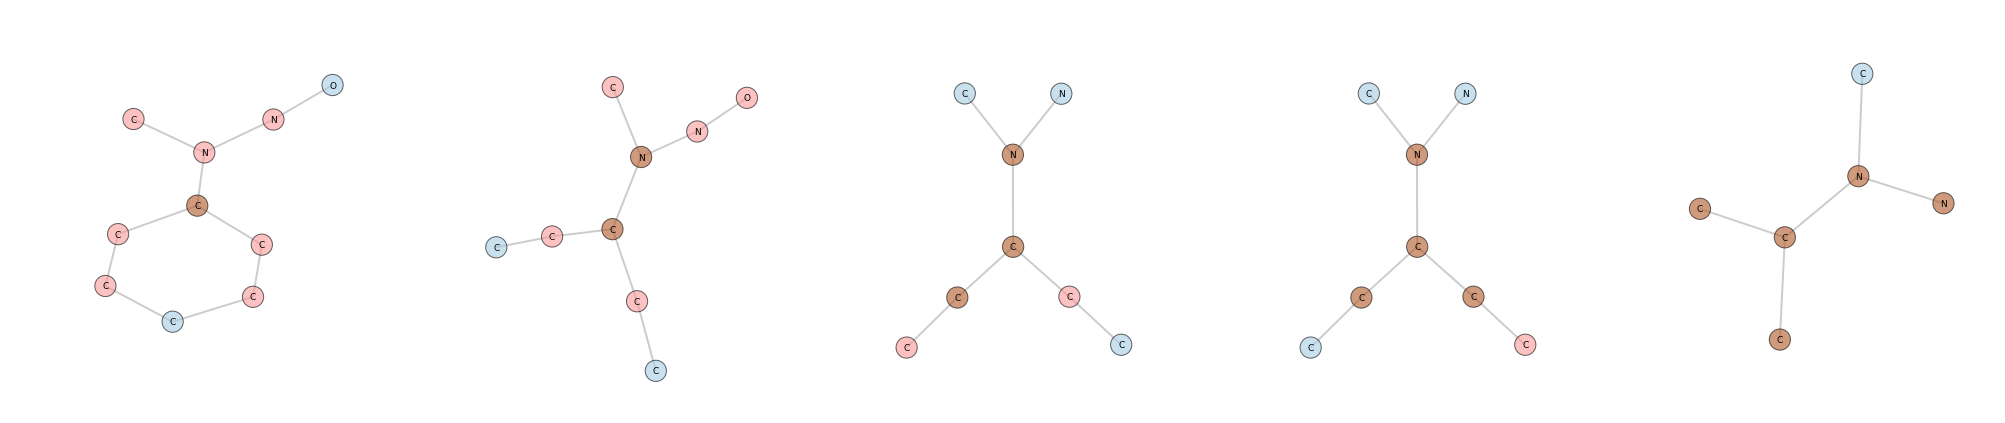

In [5]:
'''
demonstrating more extract core
'''
%matplotlib inline
import os
os.nice(20)
from eden.converter.graph.gspan import gspan_to_eden
from graphlearn.utils.draw import draw_graph_set_graphlearn
import eden.graph as eg
import graphlearn.graphlearn as gl

#get 5 grtaphs...
gr = gspan_to_eden( 'bursi.pos.gspan' )

from eden.graph import Vectorizer
v=Vectorizer()



for x in range (5):
    g=gr.next()
    #g=v._edge_to_vertex_transform(g)
    # for each, pick 5 cores and extract cips 
    #myutils.display(g,vertex_label='id')
    nice_graphs=[]
    for node in range(5):
        a=gl.extract_core_and_interface(node,g,radius_list=[2],thickness_list=[1],vectorizer=eg.Vectorizer())
        # draw cip on the original graph and save in nice_graphs
        #nice_graphs+=myutils.cip_to_graph(a, graphs=[g,g])
        newgraphs=myutils.cip_to_graph(a)
        for g,c in zip(newgraphs,a):
            g.graph['info']=str(c.interface_hash)
        nice_graphs+=newgraphs
        
    # draw nice_graphs
    myutils.draw_graph_set_graphlearn(nice_graphs, contract=False,
                           n_graphs_per_line=5, size=7, 
                           colormap='Paired', invert_colormap=False,node_border=1,
                           vertex_alpha=0.6, edge_alpha=0.2, node_size=450)

In [6]:
%%time
'''
second is reading a grammar and training an estimator
'''
import os 
os.nice(20)

import graphlearn.graphlearn as gl
from eden.converter.graph.gspan import gspan_to_eden
import itertools

# learn a grammar
training_graphs = gspan_to_eden( 'bursi.pos.gspan' )
training_size=500
training_graphs = itertools.islice(training_graphs,training_size)
sampler=gl.GraphLearnSampler(radius_list=[0,1,2],
                             thickness_list=[1.5,2],
                             min_cip_count=2, 
                             min_interface_count=3)
sampler.fit(training_graphs,n_jobs=-1,batch_size=10)
sampler.save('tmp/demo_200.ge')


Classifier:
SGDClassifier(alpha=0.000618807495069, average=False, class_weight=None,
       epsilon=0.1, eta0=0.199699247289, fit_intercept=True, l1_ratio=0.15,
       learning_rate='constant', loss='log', n_iter=92, n_jobs=1,
       penalty='l1', power_t=0.903007252288, random_state=None,
       shuffle=True, verbose=0, warm_start=False)

Predictive performance:
            accuracy: 1.000 +- 0.000
           precision: 1.000 +- 0.000
              recall: 1.000 +- 0.000
                  f1: 1.000 +- 0.000
   average_precision: 1.000 +- 0.000
             roc_auc: 1.000 +- 0.000


/Users/costa/anaconda/lib/python2.7/site-packages/sklearn/calibration.py:398: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/Users/costa/anaconda/lib/python2.7/site-packages/sklearn/calibration.py:408: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/Users/costa/anaconda/lib/python2.7/site-packages/sklearn/calibration.py:410: RuntimeWarning: invalid value encountered in multiply
  TEP_minus_T1P = P * (T * E - T1)


Saved model: tmp/demo_200.ge
CPU times: user 1min 9s, sys: 3.99 s, total: 1min 13s
Wall time: 1min 43s


interface: 327713


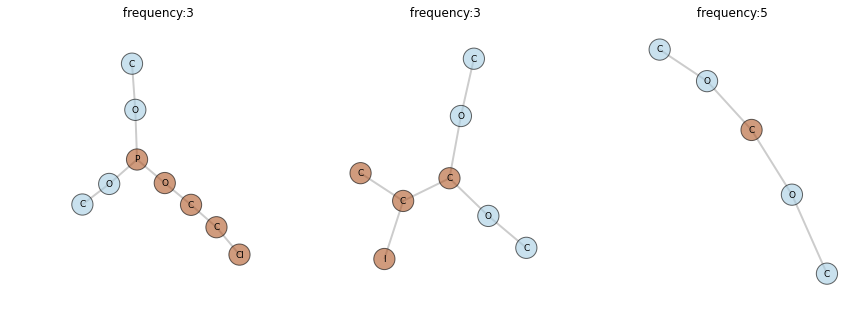

interface: 884960


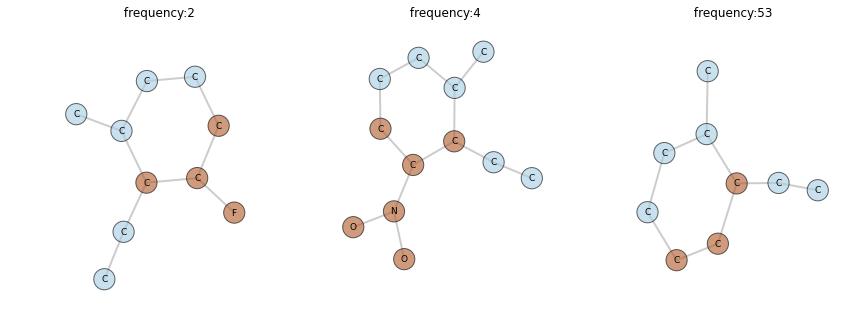

interface: 955775


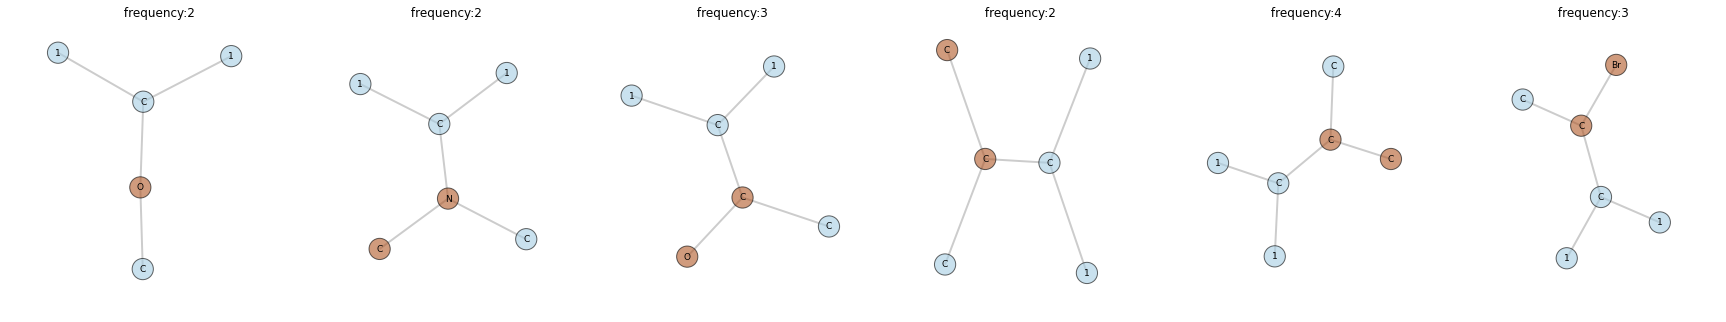

interface: 852364


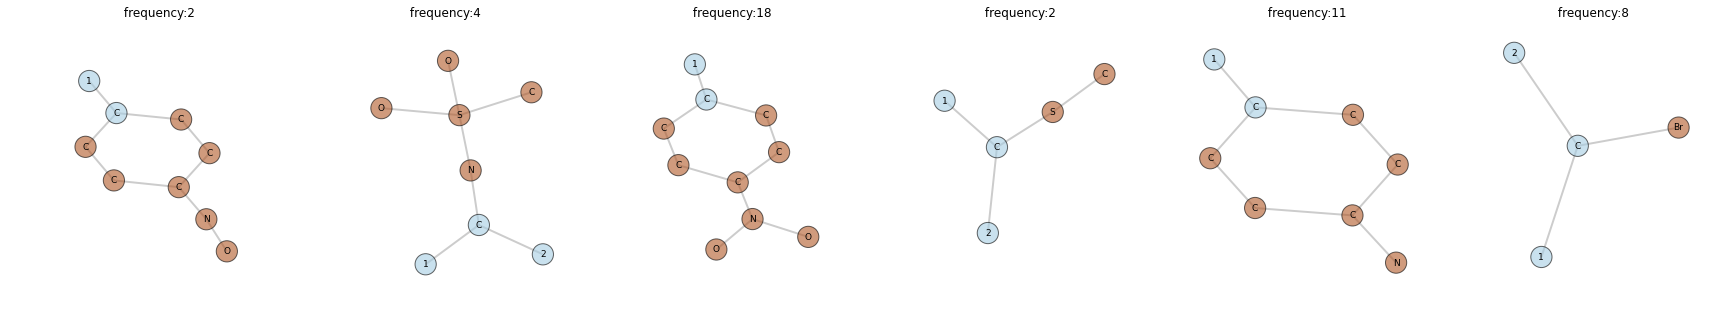

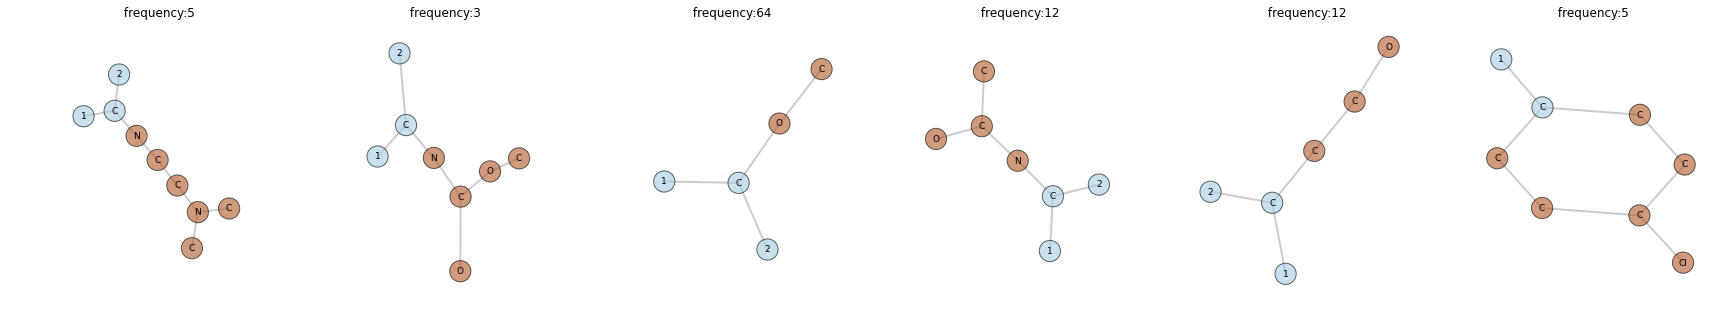

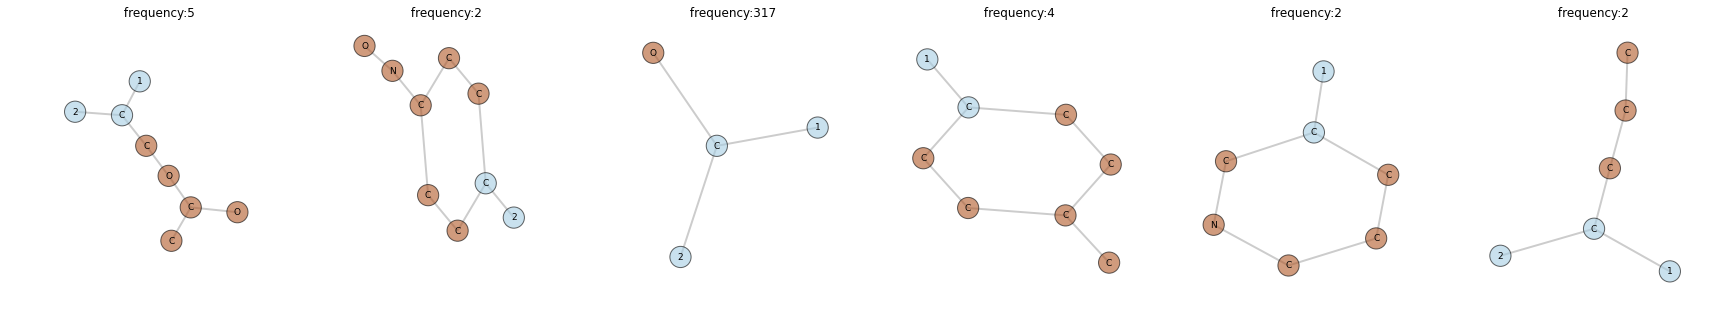

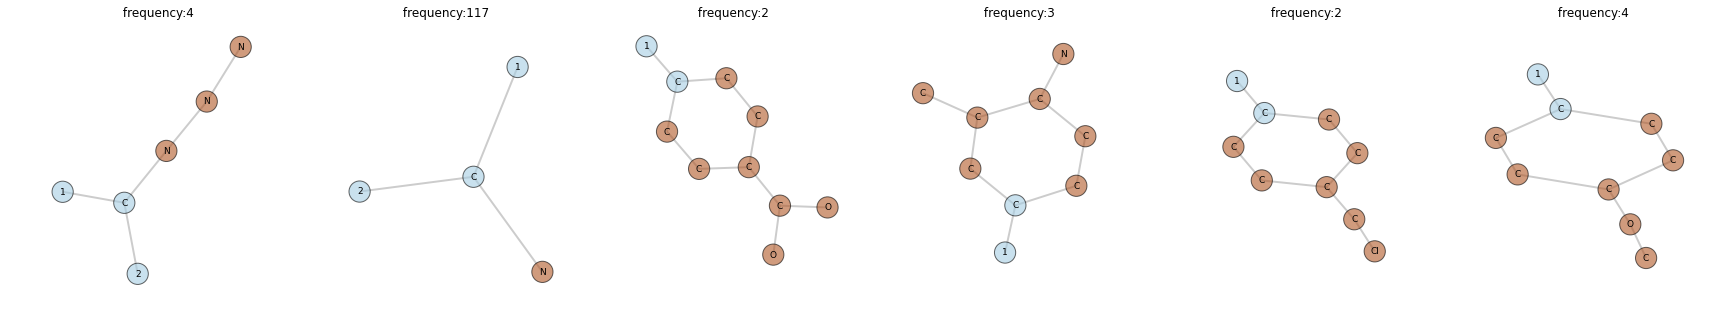

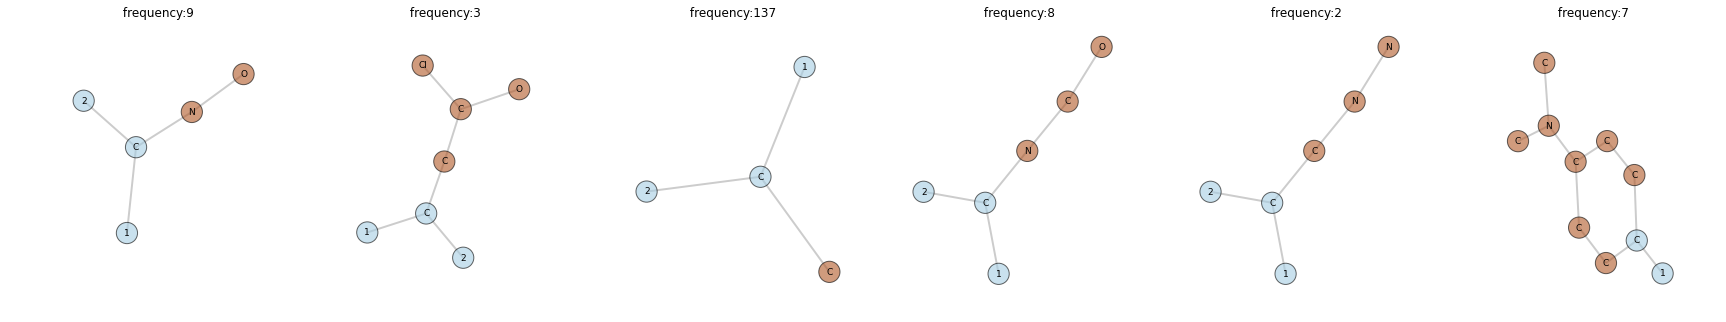

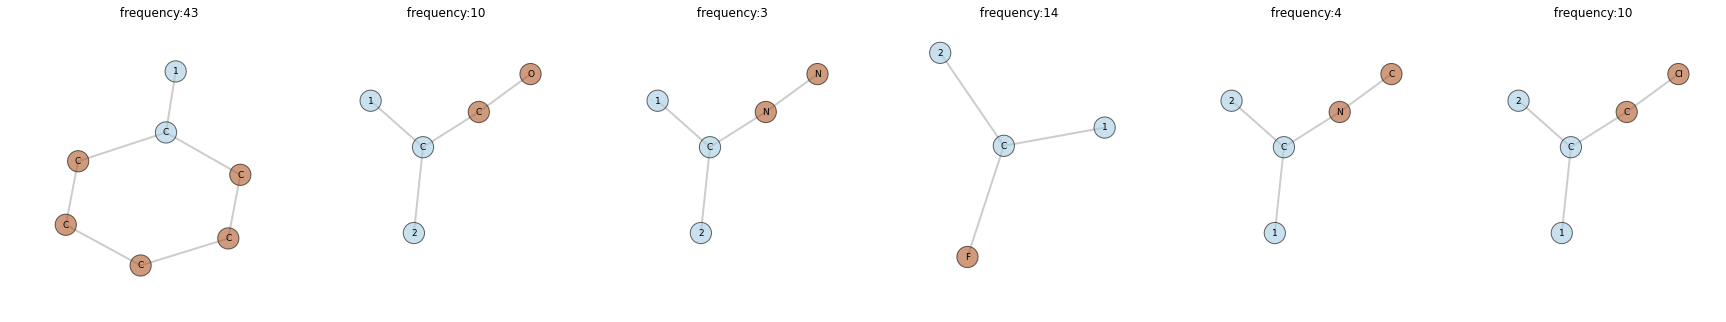

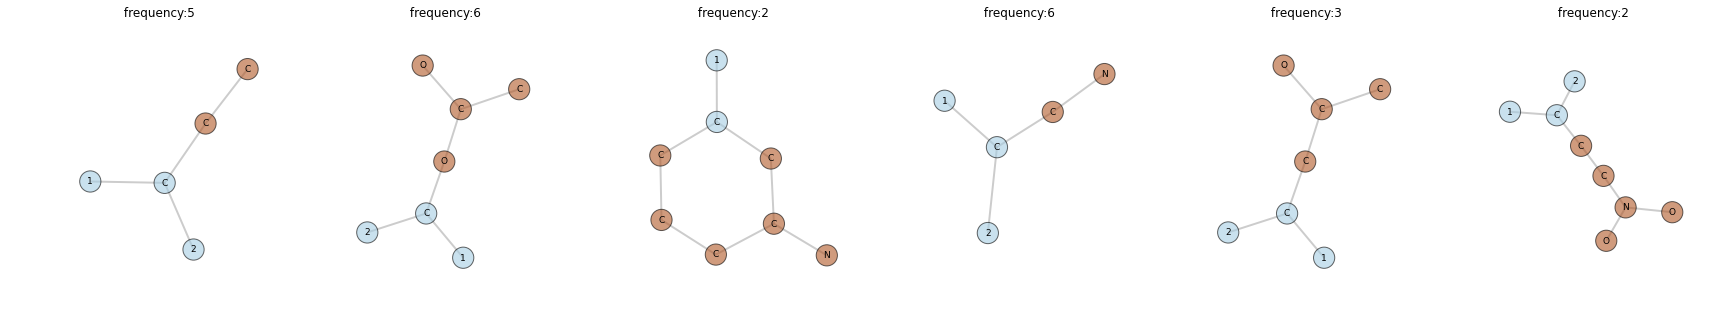

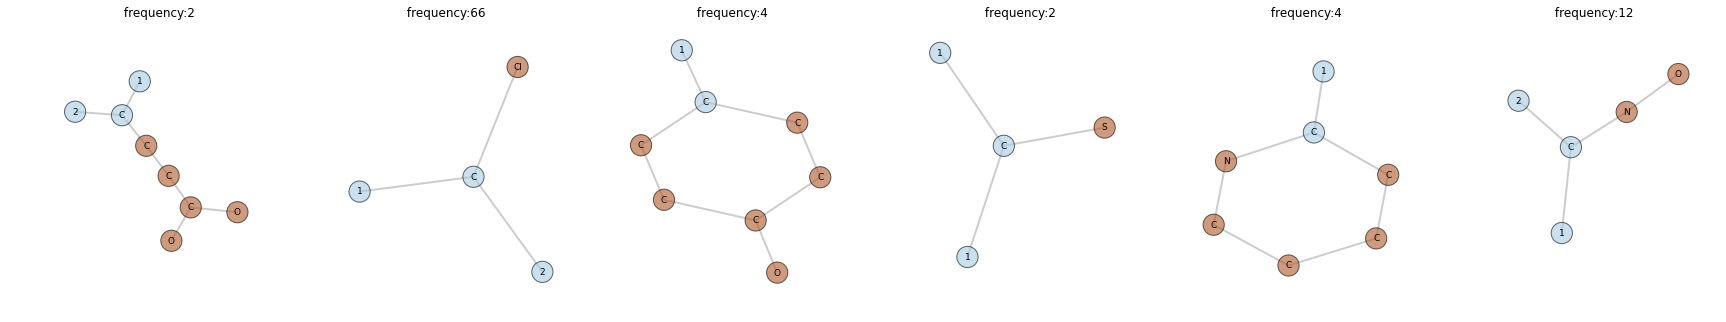

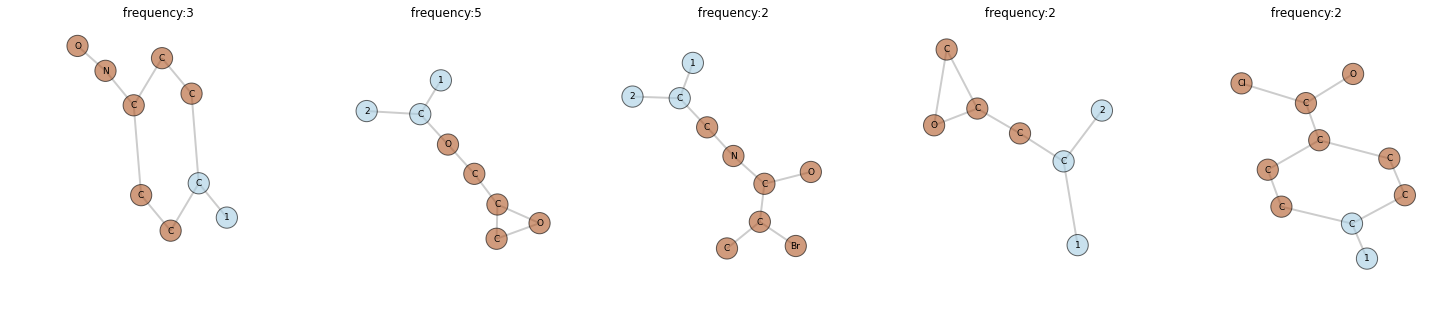

interface: 197023


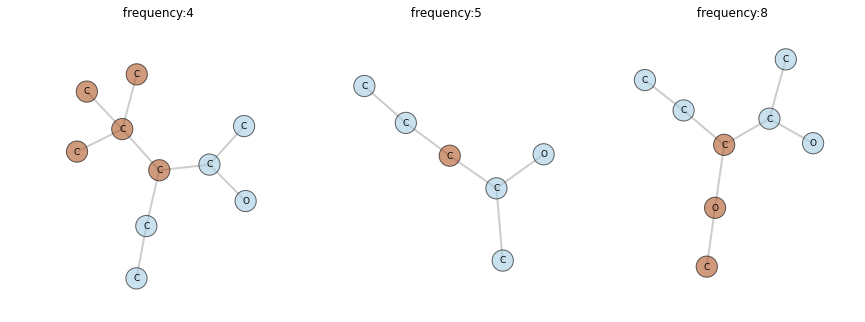

In [7]:
#draw production rules
from graphlearn.utils.draw import draw_grammar
draw_grammar(sampler.lsgg.grammar,n_productions=5,
             n_graphs_per_line=6, size=5, 
             colormap='Paired', invert_colormap=False,node_border=1,
             vertex_alpha=0.6, edge_alpha=0.2, node_size=450)

how often do we see interfacehashes
# productions: 2653
x = # interfaces (total: 406)
y=numberofcores(ihash), y=sumOfCoreCounts(ihash)


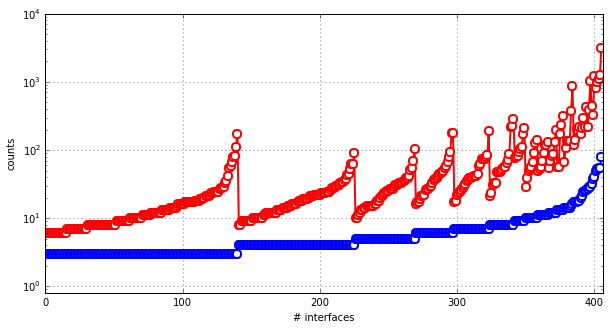

how often was this corehash seen?
x = # cores (total: 370)
y = inYinterfaces(chash), y= sumOfCountOverAllInterfaces(chash)


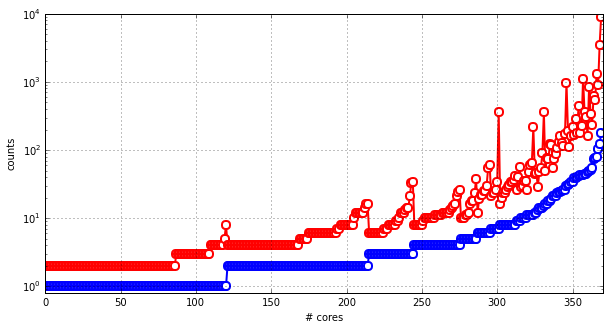

histogram
# productions: 2653
distinct cores: 370 (seen on x axis)
interfaces with x many cores were observed y many times. 


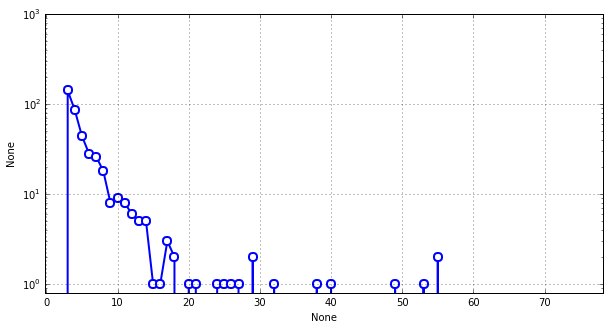

other histogram
how many cores exist with x many interfaces


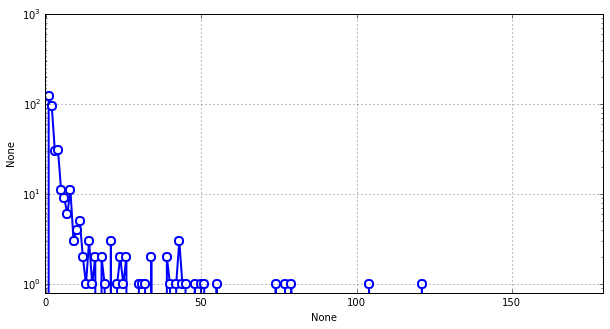

In [8]:
#grammar statistics
from graphlearn.utils.draw import draw_grammar_stats
draw_grammar_stats(sampler.lsgg.grammar, size=(10,5))

Loaded model: tmp/demo_200.ge
preprocessing grammar
_sample_notes: None
accept_annealing_factor: 1.2
accept_static_penalty: 0.0
batch_size: 1
   burnout: 1
complexity: 3
 estimator: CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=0.000618807495069, average=False, class_weight=None,
       epsilon=0.1, eta0=0.199699247289, fit_intercept=True, l1_ratio=0.15,
       learning_rate='constant', loss='log', n_iter=92, n_jobs=1,
       penalty='l1', power_t=0.903007252288, random_state=None,
       shuffle=True, verbose=0, warm_start=False),
            cv=2, method='sigmoid')
estimatorobject: <graphlearn.estimator.estimator instance at 0x10c7ad8c0>
feasibility_checker: <graphlearn.feasibility.FeasibilityChecker instance at 0x10c7ad830>
generator_mode: False
hash_bitmask: 1048575
keep_duplicates: False
      lsgg: <graphlearn.localsubstitutablegraphgrammar.LocalSubstitutableGraphGrammar object at 0x1528cc050>
    n_jobs: 1
   n_steps: 50
      nbit: 20
node_entity_check: <function <l

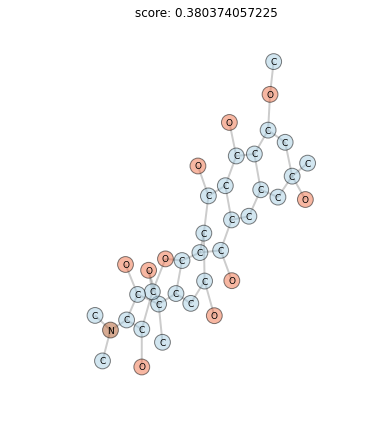

CPU times: user 11.1 s, sys: 434 ms, total: 11.6 s
Wall time: 11.7 s


In [9]:
%%time
'''
Graph sampling
'''
import sys
sys.path.append('..')
import os
os.nice(19)
%matplotlib inline
from graphlearn.utils.draw import draw_graph_set
import graphlearn.graphlearn as gl
from eden.converter.graph.gspan import gspan_to_eden
import itertools
import matplotlib.pyplot as plt
import graphlearn.utils.draw as myutils
import eden.graph as ge

sampler=gl.GraphLearnSampler()
sampler.load('tmp/demo_200.ge')
graphs = gspan_to_eden( 'bursi.pos.gspan' )
id_start=20
id_end=id_start+1
graphs = itertools.islice(graphs,id_start,id_end)
n_steps=50
sampler.feasibility_checker.draw_problem=True
graphs = sampler.sample(graphs,
                        same_radius=False,
                        same_core_size=False,
                        n_samples=4,
                        batch_size=1,
                        n_steps=n_steps,
                        n_jobs=1,
                        accept_annealing_factor=1.2,
                        probabilistic_core_choice=True,
                        burnout=1,
                        select_cip_max_tries=100,
                        keep_duplicates=False)

from eden.modifier.graph.vertex_attributes import colorize   
scores=[]
ids=range(id_start,id_end)
for i,graph in enumerate(graphs):
    print 'Graph id: %d'%(ids[i])
    scores.append(graph.graph['sampling_info']['score_history'])
    path_graphs = graph.graph['sampling_info']['graphs_history']
    path_graphs = colorize(path_graphs,
                           output_attribute = 'color_level', 
                           labels = ['C','O','N','P','Cl','Br','S','I'])
    draw_graph_set(path_graphs,
                   n_graphs_per_line=6, size=7, 
                   colormap='Paired', invert_colormap=False,node_border=0.5, vertex_color='color_level',
                   vertex_alpha=0.5, edge_alpha=0.2, node_size=250,
                   headlinehook= myutils.get_score_of_graph)

In [10]:
sampler.feasibility_checker.draw_problem

True

In [11]:
%matplotlib inline
from itertools import islice
import numpy as np
step=n_steps
step=1
num_graphs_per_plot=3
num_plots=np.ceil([len(scores)/num_graphs_per_plot])
for i in range(num_plots):
    plt.figure(figsize=(10,5))
    for j,score in enumerate(scores[i*num_graphs_per_plot:i*num_graphs_per_plot+num_graphs_per_plot]):
        data = list(islice(score,None, None, step))
        plt.plot(data, label='graph %d'%(j+i*num_graphs_per_plot+id_start))
    plt.legend(loc='lower right')
    plt.grid()
    plt.ylim(-0.1,1.1)
    plt.show()

We work on this graph


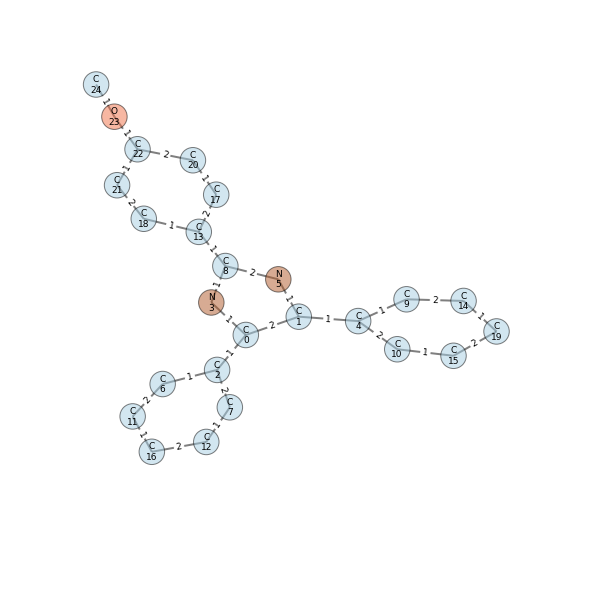

no filter


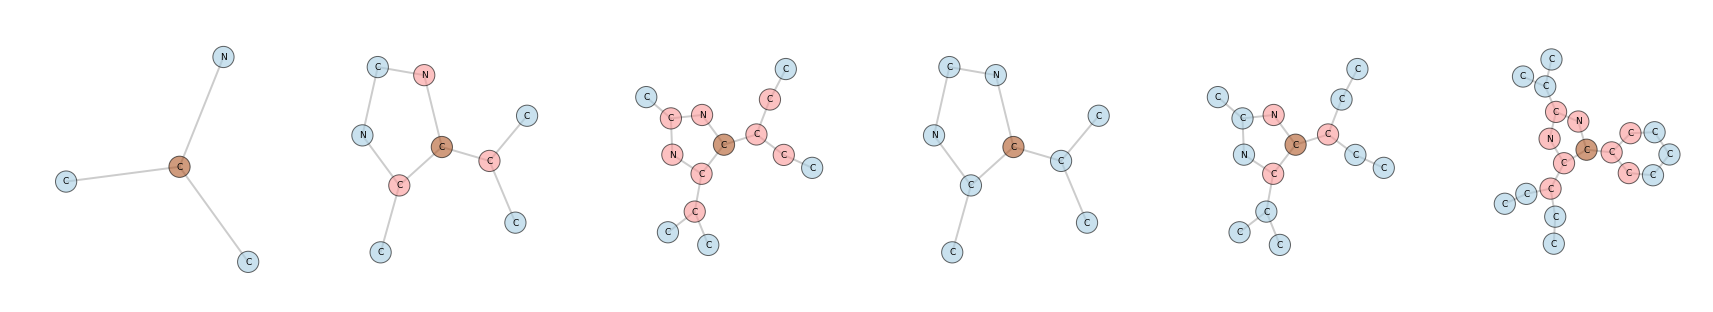

with filter: nothing should appear,,,
with filter but we chose node 2 as root


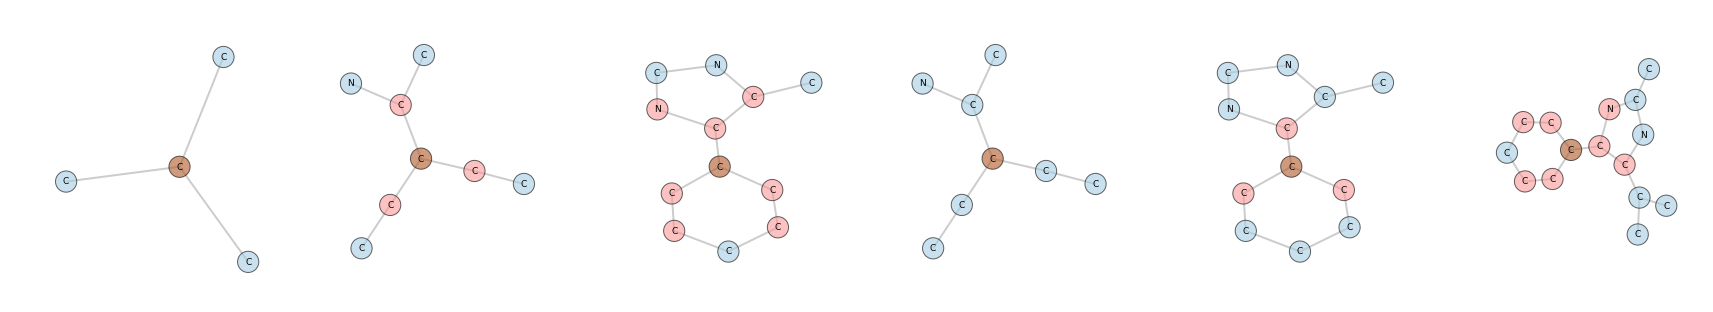

with filter but node "1" cant be part of a core, we gave 0 and 2 as radius list and only radius 2 will show up


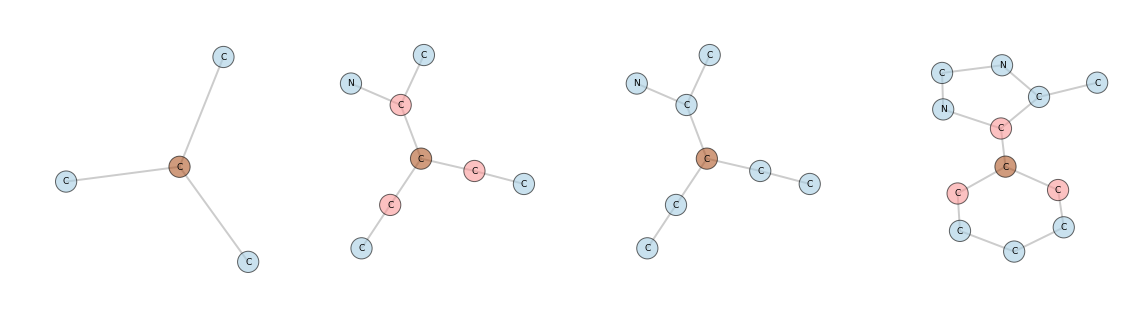

In [12]:
'''
Demonstrating the filter function
'''
import sys
sys.path.append('..')
%matplotlib inline
from eden.converter.graph.gspan import gspan_to_eden
from graphlearn import graphtools as gt
import graphlearn.utils.draw as myutils
import eden.graph as eg
import graphlearn.graphlearn as gl
import numpy as np

from eden.graph import Vectorizer
vectorizer=Vectorizer()

#get a graph
graphs = gspan_to_eden( 'bursi.pos.gspan' )
graph=graphs.next()
from eden.util import display
from eden.modifier.graph.vertex_attributes import colorize  
graphs = colorize([graph],output_attribute = 'color_level', labels = ['C','O','N','P','Cl','Br','S'])    
graph=graphs.next()
print 'We work on this graph'
display.draw_graph(graph, size=10, secondary_vertex_label='ID',
                   colormap='Paired', invert_colormap=False,node_border=0.5, vertex_color='color_level',
                   vertex_alpha=0.5, node_size=650)


def mark_and_draw(cip):
    graph=myutils.cip_to_graph(cip)
    myutils.draw_graph_set_graphlearn(graph, 
                           n_graphs_per_line=7, size=5, 
                           colormap='Paired', invert_colormap=False,node_border=1,
                           vertex_alpha=0.6, edge_alpha=0.2, node_size=450)
    
radius_list=[0,1,2]
thickness_list=[1,2]
graph.node[1]['no_root']=True
#lets see.. without filter:
cip=gl.extract_core_and_interface(1,graph,radius_list=radius_list,thickness_list=thickness_list,vectorizer=vectorizer)
print 'no filter'
mark_and_draw(cip)


# lets do the same but with the filter
cip=gl.extract_core_and_interface(1,graph,filter=gt.filter,radius_list=radius_list,thickness_list=thickness_list,vectorizer=vectorizer)
print 'with filter: nothing should appear,,,'
mark_and_draw(cip)

# filter is ignoring unfiltered things:
cip=gl.extract_core_and_interface(2,graph,filter=gt.filter,radius_list=radius_list,thickness_list=thickness_list,vectorizer=vectorizer)
print 'with filter but we chose node 2 as root'
mark_and_draw(cip)

# no core attribute
graph.node[1]["not_in_core"]=True
graph.node[1].pop('no_root')
cip=gl.extract_core_and_interface(2,graph,filter=gt.filter,radius_list=radius_list,thickness_list=thickness_list,vectorizer=vectorizer)
print 'with filter but node "1" cant be part of a core, we gave 0 and 2 as radius list and only radius 2 will show up'
mark_and_draw(cip)